In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *

### Data

In [ ]:
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-latest.zip
!unzip ml-latest.zip

--2021-05-22 10:09:23--  https://files.grouplens.org/datasets/movielens/ml-latest.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 277113433 (264M) [application/zip]
Saving to: ‘ml-latest.zip’

ml-latest.zip       100%[===================>] 264.28M  6.03MB/s    in 54s     

2021-05-22 10:10:17 (4.87 MB/s) - ‘ml-latest.zip’ saved [277113433/277113433]

Archive:  ml-latest.zip
   creating: ml-latest/
  inflating: ml-latest/links.csv     
  inflating: ml-latest/tags.csv      
  inflating: ml-latest/genome-tags.csv  
  inflating: ml-latest/ratings.csv   
  inflating: ml-latest/README.txt    
  inflating: ml-latest/genome-scores.csv  
  inflating: ml-latest/movies.csv    


In [ ]:
path = Path('ml-latest')

In [ ]:
path.ls()

(#7) [Path('ml-latest/ratings.csv'),Path('ml-latest/tags.csv'),Path('ml-latest/links.csv'),Path('ml-latest/README.txt'),Path('ml-latest/movies.csv'),Path('ml-latest/genome-tags.csv'),Path('ml-latest/genome-scores.csv')]

In [ ]:
ratings = pd.read_csv(path/'ratings.csv', skiprows=1, header=None, usecols=[0,1,2], names=['user', 'movie', 'rating'])

In [ ]:
movies = pd.read_csv(path/'movies.csv', skiprows=1, header=None, usecols=[0,1], names=['movie', 'title'])

In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,1,307,3.5,Three Colors: Blue (Trois couleurs: Bleu) (1993)
1,6,307,4.0,Three Colors: Blue (Trois couleurs: Bleu) (1993)
2,56,307,4.0,Three Colors: Blue (Trois couleurs: Bleu) (1993)
3,71,307,5.0,Three Colors: Blue (Trois couleurs: Bleu) (1993)
4,84,307,3.0,Three Colors: Blue (Trois couleurs: Bleu) (1993)


### Creating `DataLoaders`

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=1024)
dls.show_batch()

,user,title,rating
0,77481,What Planet Are You From? (2000),3.5
1,104576,Uncle Buck (1989),1.0
2,52628,Soylent Green (1973),2.0
3,144187,"Godfather: Part III, The (1990)",3.5
4,281873,Die Hard: With a Vengeance (1995),5.0
5,243020,Powder (1995),3.0
6,108348,Despicable Me 2 (2013),4.0
7,172188,RoboCop (1987),4.0
8,35392,V for Vendetta (2006),3.0
9,133865,Repo Man (1984),3.0


### Creating embeddings and a dot product-based model

In [ ]:
n_users = len(dls.classes['user'])
n_items = len(dls.classes['title'])
n_users, n_items

(281880, 53818)

In [ ]:
class DotProductBias(Module):
    def __init__(self, n_users, n_items, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.item_factors = Embedding(n_items, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.item_bias = Embedding(n_items, 1)
        self.y_range = y_range
        
    def forward(self, x):
        batch_user_factors = self.user_factors(x[:,0])
        batch_item_factors = self.item_factors(x[:,1])
        dot_product = (batch_user_factors * batch_item_factors).sum(1, keepdim=True)
        dot_product += self.user_bias(x[:,0]) + self.item_bias(x[:,1])
        return sigmoid_range(dot_product, *self.y_range)

### Running the model

In [ ]:
model = DotProductBias(n_users, n_items, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

SuggestedLRs(lr_min=0.09120108485221863, lr_steep=1.3182567499825382e-06)

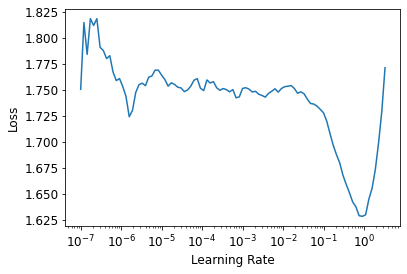

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.711024,0.710609,06:41
1,0.673985,0.685033,06:45
2,0.614553,0.644818,06:41
3,0.517764,0.617548,06:08
4,0.424235,0.623069,06:08


### Adding weight decay

In [ ]:
model = DotProductBias(n_users, n_items, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.02)

epoch,train_loss,valid_loss,time
0,0.721450,0.716621,06:06
1,0.687325,0.694229,06:06
2,0.645868,0.652978,06:03
3,0.569791,0.613664,06:05
4,0.471409,0.611206,06:03
